# Hello world

In [1]:
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from ipywidgets import Button, Layout, ButtonStyle,GridBox, VBox, HBox 
import ipywidgets as widgets
%matplotlib notebook
import tf
import numpy as np
from nav_msgs.msg import Odometry
from matplotlib.animation import FuncAnimation
from assignment_2_2022.msg import PlanningActionGoal,PlanningAction,PlanningGoal
import rospy,math
import actionlib
from std_msgs.msg import String
from geometry_msgs.msg import Twist
from sensor_msgs.msg import LaserScan 
from actionlib_msgs.msg import GoalStatusArray

rospy.init_node('user_interface', anonymous=True)
client = actionlib.SimpleActionClient('/reaching_goal', PlanningAction)

velocity_publisher = rospy.Publisher('cmd_vel',Twist, queue_size=10) 

velocity=Twist()

## Top Part

### Position And Target Plot

In [2]:
class PosTargetPlot:
    def __init__(self):
        self.fig, self.ax = plt.subplots(figsize=(5, 2))

        self.poseline, = self.ax.plot([], [], 'bo')
        self.targetline, = self.ax.plot([], [], 'rx')
        self.Pose_x = []
        self.Pose_y = []
        self.Tar_x = []
        self.Tar_y = []
 
    def plot_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        self.ax.set_title('Position and target')
        self.ax.set_xlabel('x_position')
        self.ax.set_ylabel('y_position')
    
    def odom_callback(self, msg):
        self.Pose_y.append(msg.pose.pose.position.y)
        self.Pose_x.append(msg.pose.pose.position.x)
    
    def update_plot(self, frame):
        self.poseline.set_data(self.Pose_x, self.Pose_y)
        self.targetline.set_data(self.Tar_x, self.Tar_y)
    
    
    def SetGoalCallBack(self,goal:PlanningActionGoal):
        self.Tar_x = goal.goal.target_pose.pose.position.x
        self.Tar_y = goal.goal.target_pose.pose.position.y
        self.Pose_x = []
        self.Pose_y = []


### Sample of position plot

<IPython.core.display.Javascript object>


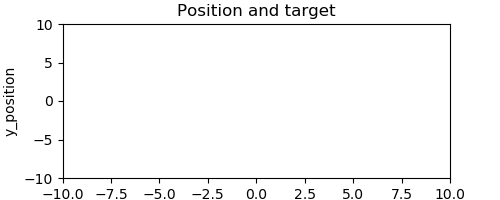

In [3]:
vis = PosTargetPlot()
sub = rospy.Subscriber('/odom', Odometry, vis.odom_callback)
ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init)
sub3 = rospy.Subscriber('/reaching_goal/goal', PlanningActionGoal, vis.SetGoalCallBack)
plt.subplots_adjust(hspace=0.4)
plt.show(block=True)

### Send Goal Form

In [4]:
placeholder_x = widgets.HTMLMath(value=r"X position")
placeholder_y = widgets.HTMLMath(value=r"Y position")
labels = widgets.VBox([placeholder_x,placeholder_y])
labels.layout.margin = 'auto 10px auto 10px'


class SendingGoal:
    def __init__(self):
        self.Tar_x = widgets.FloatText(value=0.0)
        self.Tar_y = widgets.FloatText(value=0.0)
        self.Tar_x.layout.width = '100px'
        self.Tar_y.layout.width = '100px'
        self.button = widgets.Button(description="Send Goal", button_style='' 'success' '')
        self.button.on_click(self.sendGoalcallback)
        
        
        floats = widgets.VBox([self.Tar_x,self.Tar_y])
        
        self.SendGoal = widgets.VBox([widgets.HBox([labels,floats]),self.button])
        self.SendGoal.layout.width = '30%'
        self.SendGoal.layout.margin = 'auto auto auto auto'
        
    def sendGoalcallback(self,b):
        goal = PlanningGoal()
        goal.target_pose.pose.position.x = self.Tar_x.value
        goal.target_pose.pose.position.y = self.Tar_y.value
        client.send_goal(goal)


SendGoal = SendingGoal()


### Sample of The Form

In [5]:
SendGoal.SendGoal

## Middle Part

### Robot Control Buttons

In [6]:
b1 = widgets.Button(description="^",layout=Layout(width='auto', align="center",
grid_area='b1'), button_style='' 'info' '')
b2 = widgets.Button(description="<",layout=Layout(width='auto', grid_area='b2'),
 button_style='' 'info' '')
b3 = widgets.Button(description=">",layout=Layout(width='auto', grid_area='b3'),
 button_style='' 'info' '')
b4 = widgets.Button(description="v",layout=Layout(width='auto', grid_area='b4'),
 button_style='' 'info' '')
C = widgets.Button(description="C",layout=Layout(width='auto', grid_area='C'),
 button_style='' 'danger' '')

ControlButtons = GridBox(children=[b1, b2, C, b3, b4], layout=Layout(
width='40%', height= '100px',grid_template_rows='auto auto',
    margin='auto auto auto auto',
grid_template_columns='25% 25% 25% 25%',
grid_template_areas='''
" . b1 . "
"b2 C b3 "
" . b4 . "
''')
)

In [7]:

def on_button_clickedF(b):
    velocity.linear.x=0.5
    velocity_publisher.publish(velocity)
    time.sleep(1)
    velocity.linear.x=0.0
    velocity_publisher.publish(velocity)
    rospy.loginfo('Moving Forward')
            
def on_button_clickedB(b):
        velocity.linear.x=-0.5
        velocity_publisher.publish(velocity)
        time.sleep(1)
        velocity.linear.x=0.0
        velocity_publisher.publish(velocity)
        rospy.loginfo('Moving Backword')
            
def on_button_clickedL(b):
        velocity.angular.z=1.0
        velocity_publisher.publish(velocity)
        time.sleep(1)
        velocity.angular.z=0.0
        velocity_publisher.publish(velocity)
        rospy.loginfo('Moving Left')
            
def on_button_clickedR(b):
        velocity.angular.z=-1.0
        velocity_publisher.publish(velocity)
        time.sleep(1)
        velocity.angular.z=0.0
        velocity_publisher.publish(velocity)
        rospy.loginfo('Moving Right')

def on_button_cancel(b):
    client.cancel_goal()
    rospy.loginfo("goal cancelled")
            
b1.on_click(on_button_clickedF)
b4.on_click(on_button_clickedB)
b2.on_click(on_button_clickedL)
b3.on_click(on_button_clickedR)
C.on_click(on_button_cancel)

### Separate Sample

In [8]:
ControlButtons

GridBox(children=(Button(button_style='info', description='^', layout=Layout(grid_area='b1', width='auto'), st…

### Reached Not Reached Plot

<IPython.core.display.Javascript object>


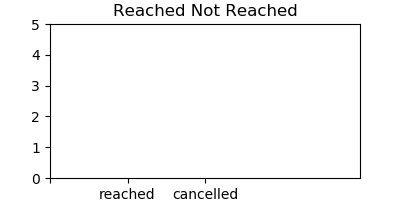

In [9]:
class PosTargetPlot:
    def __init__(self):
        self.fig, self.ax = plt.subplots(figsize=(4, 2))
        self.x=[" ","reached","cancelled"]
        self.Reached = 0
        self.NotReached = 0
        self.y=[0,self.Reached,self.NotReached]
        self.ln3 = self.ax.bar(self.x,self.y)
        self.ax.set_xlim(0, 4)
        self.ax.set_ylim(0, 5)
        self.ax.set_title('Reached Not Reached')

    def topicCallback(self, msg:String):
        
        if msg.data[0] =='R':
            self.Reached = int(msg.data[2:])
        elif msg.data[0] =='C':
            self.NotReached = int(msg.data[2:])
        else:
            return None
        
        self.y=[0,self.Reached,self.NotReached]
        self.ln3 = self.ax.bar(self.x,self.y,color='green')
    
ReachedNotR = PosTargetPlot()




sub3 = rospy.Subscriber('/custom_service_topic', String, ReachedNotR.topicCallback)

## Bottom Part

### Display nearest distance

In [10]:
def scan_callback(scan_data:LaserScan):
    # Get the range values from the laser scan
    ranges = scan_data.ranges

    # Find the minimum range value and its index
    min_range = min(ranges)
    distance.value = round(min_range,2)
    min_range_index = ranges.index(min_range)

    # Get the angle corresponding to the minimum range
    angle = scan_data.angle_min + (min_range_index * scan_data.angle_increment)

    # Calculate the (x, y) coordinates of the nearest obstacle
    coo_x_v.value = round(min_range * math.cos(angle),2)
    coo_y_v.value = round(min_range * math.sin(angle),2)
    

    
rospy.Subscriber('/scan', LaserScan, scan_callback)

In [11]:
label_x = widgets.HTMLMath(value=r"X coordinate: ")
label_y = widgets.HTMLMath(value=r"Y coordinate: ")

label_distance = widgets.HTMLMath(value=r"Distance: ")
label_distance.layout.margin = 'auto 10px auto 10px'
distance = widgets.FloatText(value='0.0', disabled=True)
distance.layout.margin = 'auto 10px auto 10px'

coo_x_v = widgets.FloatText(value='0.0', disabled=True)
coo_y_v = widgets.FloatText(value='0.0', disabled=True)

coo_x = widgets.HBox([label_x,coo_x_v])
coo_y = widgets.HBox([label_y,coo_y_v])
coo_x.layout.margin = 'auto auto auto auto'
coo_y.layout.margin = 'auto auto auto auto'
coordinates = widgets.VBox([coo_x,coo_y],layout=Layout(height='100%'))


distance_label = widgets.HBox([label_distance,distance],layout=Layout(height='100%',margin='0 50px 0 0'))

bottomPart = widgets.HBox([distance_label,coordinates],layout=Layout(height='100px'))
bottomPart



#### Note :

I added the coordinate of the nearest obstical in the robot frame ..

## Put Everything together

In [12]:

plot_widget = widgets.HBox([widgets.Output(layout=Layout(width ='70%',height='100%')),SendGoal.SendGoal])
plot_widget.layout.height = '300px'

middle = widgets.HBox([ControlButtons,widgets.Output(layout=Layout(width ='60%',height='100%'))])
middle.layout.height = '300px'

tr = widgets.VBox([plot_widget,middle,bottomPart])

display(tr)
with middle.children[1]:
    display(ReachedNotR.fig)
    
with plot_widget.children[0]:
    display(vis.fig)